In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split, RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score
from sklearn.feature_selection import RFECV

from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical 

from matplotlib import style

plt.style.use('dark_background')
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['red'])

In [2]:
df = pd.read_csv('./BankChurners.csv')
df.drop(columns=['Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1', 'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'], inplace=True)
df.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


In [3]:
df.columns


Index(['CLIENTNUM', 'Attrition_Flag', 'Customer_Age', 'Gender',
       'Dependent_count', 'Education_Level', 'Marital_Status',
       'Income_Category', 'Card_Category', 'Months_on_book',
       'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio'],
      dtype='object')

In [4]:
df['Marital_Status'].unique()

array(['Married', 'Single', 'Unknown', 'Divorced'], dtype=object)

In [5]:
#Preparing data

df['Attrition_Flag'].mask(df['Attrition_Flag'] == 'Existing Customer', 1, inplace=True)
df['Attrition_Flag'].mask(df['Attrition_Flag'] == 'Attrited Customer', 0, inplace=True)
df['Gender'].mask(df['Gender'] == 'M', 1, inplace=True)
df['Gender'].mask(df['Gender'] == 'F', 0, inplace=True)

#Sort education from the lowest level to the highest

df['Education_Level'].mask(df['Education_Level'] == 'Unknown', 0, inplace=True)
df['Education_Level'].mask(df['Education_Level'] == 'Uneducated', -3, inplace=True)
df['Education_Level'].mask(df['Education_Level'] == 'High School', -2, inplace=True)
df['Education_Level'].mask(df['Education_Level'] == 'College', -1, inplace=True)
df['Education_Level'].mask(df['Education_Level'] == 'Graduate', 1, inplace=True)
df['Education_Level'].mask(df['Education_Level'] == 'Post-Graduate', 2, inplace=True)
df['Education_Level'].mask(df['Education_Level'] == 'Doctorate', 3, inplace=True)


In [6]:
#marital status (decided to add binary variables)

df['Marital_Status_Married'] = (df['Marital_Status'] == 'Married').astype(int)
df['Marital_Status_Single'] = (df['Marital_Status'] == 'Single').astype(int)
df['Marital_Status_Divorced'] = (df['Marital_Status'] == 'Divorced').astype(int)
df = df[df['Marital_Status'] != 'Unknown']


In [7]:
df['Income_Category'].unique()

array(['$60K - $80K', 'Less than $40K', '$80K - $120K', '$40K - $60K',
       '$120K +', 'Unknown'], dtype=object)

In [8]:
df['Card_Category'].unique()

array(['Blue', 'Gold', 'Silver', 'Platinum'], dtype=object)

In [9]:
#card category values can be sorted from the worst to the best

df['Card_Category'].mask(df['Card_Category'] == 'Blue', 0, inplace=True)
df['Card_Category'].mask(df['Card_Category'] == 'Silver', 1, inplace=True)
df['Card_Category'].mask(df['Card_Category'] == 'Gold', 2, inplace=True)
df['Card_Category'].mask(df['Card_Category'] == 'Platinum', 3, inplace=True)

In [10]:
#binary variables for income level

df['Income_Category_less40'] = (df['Income_Category'] == 'Less than $40K').astype(int)
df['Income_Category_40-60'] = (df['Income_Category'] == '$40K - $60K').astype(int)
df['Income_Category_60-80'] = (df['Income_Category'] == '$60K - $80K').astype(int)
df['Income_Category_80-120'] = (df['Income_Category'] == '$80K - $120K').astype(int)
df['Income_Category_120+'] = (df['Income_Category'] == '$120K +').astype(int)
df = df[df['Income_Category'] != 'Unknown']


In [11]:
pd.set_option('display.max_columns', None)
df.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Marital_Status_Married,Marital_Status_Single,Marital_Status_Divorced,Income_Category_less40,Income_Category_40-60,Income_Category_60-80,Income_Category_80-120,Income_Category_120+
0,768805383,1,45,1,3,-2,Married,$60K - $80K,0,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,1,0,0,0,0,1,0,0
1,818770008,1,49,0,5,1,Single,Less than $40K,0,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0,1,0,1,0,0,0,0
2,713982108,1,51,1,3,1,Married,$80K - $120K,0,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,1,0,0,0,0,0,1,0
4,709106358,1,40,1,3,-3,Married,$60K - $80K,0,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000,1,0,0,0,0,1,0,0
5,713061558,1,44,1,2,1,Married,$40K - $60K,0,36,3,1,2,4010.0,1247,2763.0,1.376,1088,24,0.846,0.311,1,0,0,0,1,0,0,0


In [12]:
#defining variables

X = df.drop(columns=['CLIENTNUM', 'Marital_Status', 'Income_Category', 'Attrition_Flag'])
y = df['Attrition_Flag'].astype('int')

In [13]:
#splitting into train and test sets

idx_train, idx_test = train_test_split(X.index, stratify=y, random_state=999)

X_train, X_test = X.loc[idx_train], X.loc[idx_test]
y_train, y_test = y[idx_train], y[idx_test]

In [36]:
selector = RFECV(estimator=RandomForestClassifier(max_depth=3, min_samples_split=5, min_samples_leaf=15, max_leaf_nodes=11), step=1, cv=RepeatedStratifiedKFold(n_repeats=1, n_splits=5), min_features_to_select=7)
selector.fit(X_train, y_train)

RFECV(cv=RepeatedStratifiedKFold(n_repeats=1, n_splits=5, random_state=None),
      estimator=RandomForestClassifier(max_depth=3, max_leaf_nodes=11,
                                       min_samples_leaf=15,
                                       min_samples_split=5),
      min_features_to_select=7)

In [37]:
k=0
for i in X_train.columns:
    print(i, ': ', selector.support_[k])
    k += 1

Customer_Age :  False
Gender :  False
Dependent_count :  False
Education_Level :  False
Card_Category :  False
Months_on_book :  False
Total_Relationship_Count :  False
Months_Inactive_12_mon :  False
Contacts_Count_12_mon :  False
Credit_Limit :  False
Total_Revolving_Bal :  True
Avg_Open_To_Buy :  False
Total_Amt_Chng_Q4_Q1 :  False
Total_Trans_Amt :  True
Total_Trans_Ct :  True
Total_Ct_Chng_Q4_Q1 :  True
Avg_Utilization_Ratio :  True
Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1 :  True
Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2 :  True
Marital_Status_Married :  False
Marital_Status_Single :  False
Marital_Status_Divorced :  False
Income_Category_less40 :  False
Income_Category_40-60 :  False
Income_Category_60-80 :  False
Income_Category_80-120 :  False
Income_Category_120+ :  False


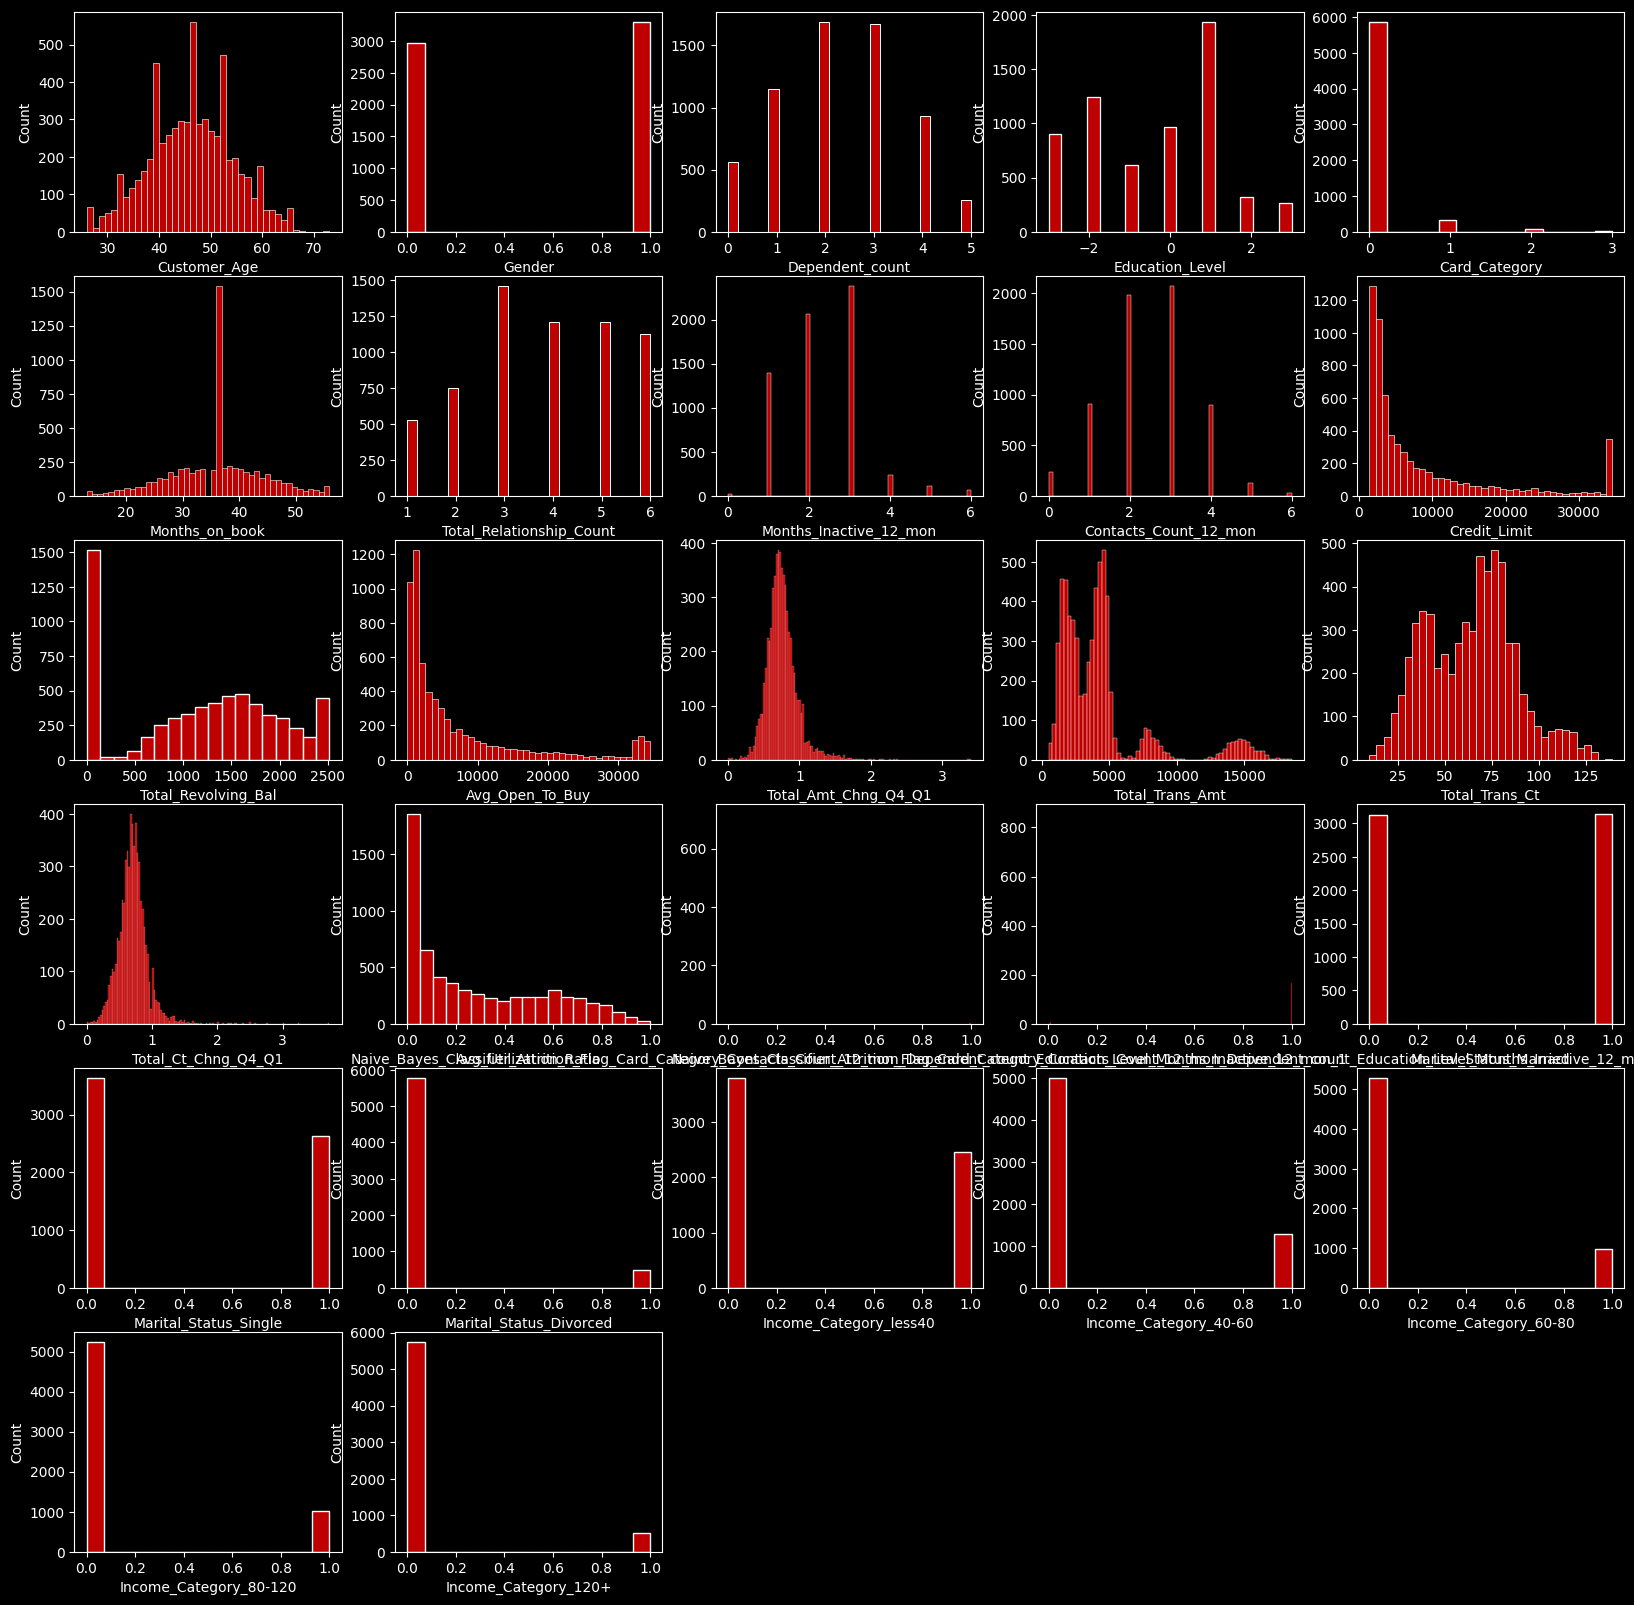

In [38]:
plt.figure(figsize=(20,20))
k=1
for i in X_train.columns:
    plt.subplot(6,5,k)
    sns.histplot(X_train[i])
    k+=1
plt.show()

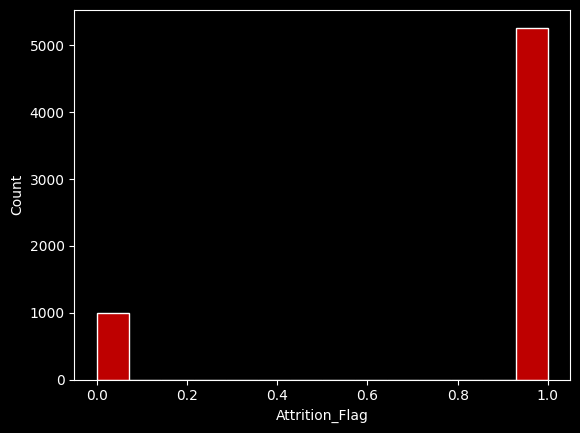

In [39]:
sns.histplot(y_train)
plt.show()

Data is unbalanced, so accuracy is not the best metrics. <br>
I will compare metrics like roc_auc, f1, precision and recall.

In [40]:
#scaling data

scaler = MinMaxScaler(feature_range=(0,1)).fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [42]:
#svc

svc = SVC(kernel='linear')
svc.fit(X_train_scaled, y_train)
y_svc = svc.predict(X_test_scaled)
print('ROC AUC score: ', roc_auc_score(y_svc,y_test))
print('F1 score: ', f1_score(y_svc,y_test))
print('Precision score: ', precision_score(y_svc,y_test))
print('Recall score: ', recall_score(y_svc,y_test))


ROC AUC score:  1.0
F1 score:  1.0
Precision score:  1.0
Recall score:  1.0


In [44]:
#Logistic Regression

lr = LogisticRegression(random_state=123, max_iter=1000)
lr.fit(X_train_scaled, y_train)
y_lr = lr.predict(X_test_scaled)
print('ROC AUC score: ', roc_auc_score(y_lr,y_test))
print('F1 score: ', f1_score(y_lr,y_test))
print('Precision score: ', precision_score(y_lr,y_test))
print('Recall score: ', recall_score(y_lr,y_test))


ROC AUC score:  1.0
F1 score:  1.0
Precision score:  1.0
Recall score:  1.0


In [19]:
#GaussianNaiveBayes

gnb = GaussianNB()
gnb.fit(X_train_scaled, y_train)
y_gnb = gnb.predict(X_test_scaled)
print('ROC AUC score: ', roc_auc_score(y_gnb,y_test))
print('F1 score: ', f1_score(y_gnb,y_test))
print('Precision score: ', precision_score(y_gnb,y_test))
print('Recall score: ', recall_score(y_gnb,y_test))

ROC AUC score:  0.7895487093352194
F1 score:  0.9368160960112955
Precision score:  0.9351656095842142
Recall score:  0.9384724186704385


In [20]:
#KNeighbors

knc = KNeighborsClassifier()
knc.fit(X_train_scaled, y_train)
y_knc = knc.predict(X_test_scaled)
print('ROC AUC score: ', roc_auc_score(y_knc,y_test))
print('F1 score: ', f1_score(y_knc,y_test))
print('Precision score: ', precision_score(y_knc,y_test))
print('Recall score: ', recall_score(y_knc,y_test))

#searching for best hyperparameters

params = {
    'n_neighbors': range(1,11),
    'p':range(1,4)
}
print('\nMetrics after searching for hyperparameters: ')
rs = RandomizedSearchCV(knc, params, n_iter=10, cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=5))
rs.fit(X_train_scaled, y_train)
y_pred = rs.predict(X_test_scaled)
print('ROC AUC score: ', roc_auc_score(y_pred,y_test))
print('F1 score: ', f1_score(y_pred,y_test))
print('Precision score: ', precision_score(y_pred,y_test))
print('Recall score: ', recall_score(y_pred,y_test))

print('\n%change due to hyperparameters optimalization:')
print('ROC AUC score % change: ', 1 - (roc_auc_score(y_pred,y_test)/roc_auc_score(y_knc,y_test)), '%')
print('F1 score % change: ', 1 - (f1_score(y_pred,y_test)/f1_score(y_knc,y_test)), '%')
print('Precision score % change: ', 1 - (precision_score(y_pred,y_test)/precision_score(y_knc,y_test)), '%')
print('Recall score % change: ', 1 - (recall_score(y_pred,y_test)/recall_score(y_knc,y_test)), '%')


ROC AUC score:  0.8448830467415909
F1 score:  0.9428571428571427
Precision score:  0.9767441860465116
Recall score:  0.9112426035502958

Metrics after searching for hyperparameters: 
ROC AUC score:  0.8540706605222734
F1 score:  0.9493627282121943
Precision score:  0.971106412966878
Recall score:  0.9285714285714286

%change due to hyperparameters optimalization:
ROC AUC score % change:  -0.010874420804294571 %
F1 score % change:  -0.00689986325535763 %
Precision score % change:  0.005772005772005762 %
Recall score % change:  -0.019016697588126297 %


In [21]:
rs.best_params_

{'p': 1, 'n_neighbors': 6}

In [33]:
#Decision Tree

dtc = DecisionTreeClassifier(random_state=random_state)
dtc.fit(X_train_scaled, y_train)
y_dtc = dtc.predict(X_test_scaled)
print('ROC AUC score: ', roc_auc_score(y_dtc,y_test))
print('F1 score: ', f1_score(y_dtc,y_test))
print('Precision score: ', precision_score(y_dtc,y_test))
print('Recall score: ', recall_score(y_dtc,y_test))

params = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': range(1,5),
    'min_samples_split': range(2,10),
    'min_samples_leaf': range(1,25),
    'max_leaf_nodes': range(5,15)
}

print('\nMetrics after searching for hyperparameters: ')
rs = RandomizedSearchCV(dtc, params, n_iter=15, cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=5))
rs.fit(X_train_scaled, y_train)
y_pred = rs.predict(X_test_scaled)
print('ROC AUC score: ', roc_auc_score(y_pred,y_test))
print('F1 score: ', f1_score(y_pred,y_test))
print('Precision score: ', precision_score(y_pred,y_test))
print('Recall score: ', recall_score(y_pred,y_test))

print('\n%change due to hyperparameters optimalization:')
print('ROC AUC score % change: ', 1 - (roc_auc_score(y_pred,y_test)/roc_auc_score(y_dtc,y_test)), '%')
print('F1 score % change: ', 1 - (f1_score(y_pred,y_test)/f1_score(y_dtc,y_test)), '%')
print('Precision score % change: ', 1 - (precision_score(y_pred,y_test)/precision_score(y_dtc,y_test)), '%')
print('Recall score % change: ', 1 - (recall_score(y_pred,y_test)/recall_score(y_dtc,y_test)), '%')



ROC AUC score:  0.8634583758609272
F1 score:  0.9597173144876325
Precision score:  0.9570119802677942
Recall score:  0.96243798724309

Metrics after searching for hyperparameters: 
ROC AUC score:  0.8607862686331968
F1 score:  0.955944055944056
Precision score:  0.9633544749823819
Recall score:  0.9486467730742539

%change due to hyperparameters optimalization:
ROC AUC score % change:  0.0030946566764913364 %
F1 score % change:  0.00393163537493435 %
Precision score % change:  -0.006627393225331346 %
Recall score % change:  0.014329457431684678 %


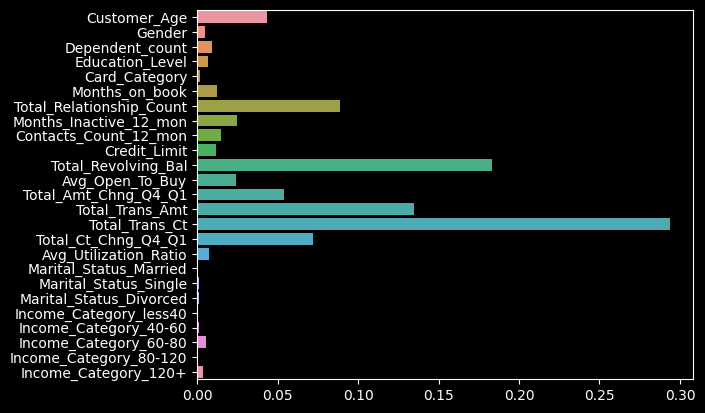

In [46]:
sns.barplot(x=dtc.feature_importances_, y=df[['Customer_Age', 'Gender', 'Dependent_count', 'Education_Level', 'Card_Category', 'Months_on_book', 'Total_Relationship_Count', 'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal', 'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt', 'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio', 'Marital_Status_Married', 'Marital_Status_Single', 'Marital_Status_Divorced', 'Income_Category_less40', 'Income_Category_40-60', 'Income_Category_60-80', 'Income_Category_80-120', 'Income_Category_120+']].columns)
plt.show()

In [34]:
rs.best_params_

{'min_samples_split': 9,
 'min_samples_leaf': 4,
 'max_leaf_nodes': 13,
 'max_depth': 4,
 'criterion': 'entropy'}

In [58]:
#Random Forest

rfc = RandomForestClassifier(random_state=random_state)
rfc.fit(X_train_scaled, y_train)
y_rfc = rfc.predict(X_test_scaled)
print('ROC AUC score: ', roc_auc_score(y_rfc,y_test))
print('F1 score: ', f1_score(y_rfc,y_test))
print('Precision score: ', precision_score(y_rfc,y_test))
print('Recall score: ', recall_score(y_rfc,y_test))

params = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': range(1,5),
    'min_samples_split': range(2,10),
    'min_samples_leaf': range(1,25),
    'max_leaf_nodes': range(5,15)
}

print('\nMetrics after searching for hyperparameters: ')
rs = RandomizedSearchCV(dtc, params, n_iter=15, cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=5))
rs.fit(X_train_scaled, y_train)
y_pred = rs.predict(X_test_scaled)
print('ROC AUC score: ', roc_auc_score(y_pred,y_test))
print('F1 score: ', f1_score(y_pred,y_test))
print('Precision score: ', precision_score(y_pred,y_test))
print('Recall score: ', recall_score(y_pred,y_test))

print('\n%change due to hyperparameters optimalization:')
print('ROC AUC score % change: ', 1 - (roc_auc_score(y_pred,y_test)/roc_auc_score(y_dtc,y_test)), '%')
print('F1 score % change: ', 1 - (f1_score(y_pred,y_test)/f1_score(y_dtc,y_test)), '%')
print('Precision score % change: ', 1 - (precision_score(y_pred,y_test)/precision_score(y_dtc,y_test)), '%')
print('Recall score % change: ', 1 - (recall_score(y_pred,y_test)/recall_score(y_dtc,y_test)), '%')



ROC AUC score:  0.951836773563793
F1 score:  0.982136602451839
Precision score:  0.9880197322057788
Recall score:  0.9763231197771588

Metrics after searching for hyperparameters: 
ROC AUC score:  0.8516653665224687
F1 score:  0.9540834209603924
Precision score:  0.9591261451726568
Recall score:  0.9490934449093444

%change due to hyperparameters optimalization:
ROC AUC score % change:  0.013657878211789987 %
F1 score % change:  0.005870367703272983 %
Precision score % change:  -0.0022091310751104487 %
Recall score % change:  0.01386535289610824 %


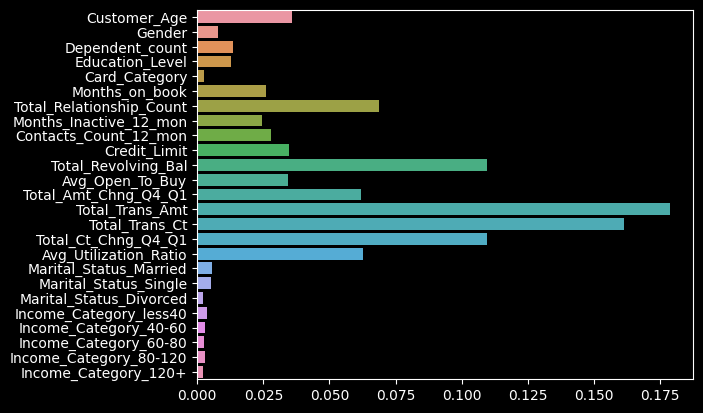

In [62]:
sns.barplot(x=rfc.feature_importances_, y=df[['Customer_Age', 'Gender', 'Dependent_count', 'Education_Level', 'Card_Category', 'Months_on_book', 'Total_Relationship_Count', 'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal', 'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt', 'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio', 'Marital_Status_Married', 'Marital_Status_Single', 'Marital_Status_Divorced', 'Income_Category_less40', 'Income_Category_40-60', 'Income_Category_60-80', 'Income_Category_80-120', 'Income_Category_120+']].columns)
plt.show()

In [59]:
rs.best_params_

{'min_samples_split': 5,
 'min_samples_leaf': 15,
 'max_leaf_nodes': 11,
 'max_depth': 3,
 'criterion': 'gini'}